# Import Libraries

In [209]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import NMF
from sklearn.decomposition import LatentDirichletAllocation as LDA
import json
import re
import spacy
from unidecode import unidecode

# Import dataset

In [210]:
data = pd.read_csv('./Amazon reviews dataset/amzn_reviews.csv')
data.head()

,id,asins,brand,categories,colors,dateAdded,dateUpdated,dimension,ean,keys,...,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username,sizes,upc,weight
0,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,2016-03-08T20:21:53Z,2017-07-18T23:52:58Z,169 mm x 117 mm x 9.1 mm,NaN,kindlepaperwhite/b00qjdu3ky,...,5.0,https://www.amazon.com/Kindle-Paperwhite-High-...,I initially had trouble deciding between the p...,"Paperwhite voyage, no regrets!",NaN,NaN,Cristina M,NaN,NaN,205 grams
1,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,2016-03-08T20:21:53Z,2017-07-18T23:52:58Z,169 mm x 117 mm x 9.1 mm,NaN,kindlepaperwhite/b00qjdu3ky,...,5.0,https://www.amazon.com/Kindle-Paperwhite-High-...,Allow me to preface this with a little history...,One Simply Could Not Ask For More,NaN,NaN,Ricky,NaN,NaN,205 grams
2,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,2016-03-08T20:21:53Z,2017-07-18T23:52:58Z,169 mm x 117 mm x 9.1 mm,NaN,kindlepaperwhite/b00qjdu3ky,...,4.0,https://www.amazon.com/Kindle-Paperwhite-High-...,I am enjoying it so far. Great for reading. Ha...,Great for those that just want an e-reader,NaN,NaN,Tedd Gardiner,NaN,NaN,205 grams
3,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,2016-03-08T20:21:53Z,2017-07-18T23:52:58Z,169 mm x 117 mm x 9.1 mm,NaN,kindlepaperwhite/b00qjdu3ky,...,5.0,https://www.amazon.com/Kindle-Paperwhite-High-...,I bought one of the first Paperwhites and have...,Love / Hate relationship,NaN,NaN,Dougal,NaN,NaN,205 grams
4,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,2016-03-08T20:21:53Z,2017-07-18T23:52:58Z,169 mm x 117 mm x 9.1 mm,NaN,kindlepaperwhite/b00qjdu3ky,...,5.0,https://www.amazon.com/Kindle-Paperwhite-High-...,I have to say upfront - I don't like coroporat...,I LOVE IT,NaN,NaN,Miljan David Tanic,NaN,NaN,205 grams


# Data Pre-processing

In [211]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1597 entries, 0 to 1596
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    1597 non-null   object 
 1   asins                 1597 non-null   object 
 2   brand                 1597 non-null   object 
 3   categories            1597 non-null   object 
 4   colors                774 non-null    object 
 5   dateAdded             1597 non-null   object 
 6   dateUpdated           1597 non-null   object 
 7   dimension             565 non-null    object 
 8   ean                   898 non-null    float64
 9   keys                  1597 non-null   object 
 10  manufacturer          965 non-null    object 
 11  manufacturerNumber    902 non-null    object 
 12  name                  1597 non-null   object 
 13  prices                1597 non-null   object 
 14  reviews.date          1217 non-null   object 
 15  reviews.doRecommend  

In [212]:
data.drop_duplicates(inplace=True)

In [213]:
data['prices'] = data['prices'].apply(lambda x : json.loads(x)[0]['amountMax'])

In [214]:
data['dateAdded'] = data['dateAdded'].apply(pd.Timestamp)

# Feature Engineering

In [215]:
data = data[['name', 'prices', 'dateAdded', 'reviews.text', 'reviews.rating']]

In [216]:
data.head()

,name,prices,dateAdded,reviews.text,reviews.rating
0,Kindle Paperwhite,139.99,2016-03-08 20:21:53+00:00,I initially had trouble deciding between the p...,5.0
1,Kindle Paperwhite,139.99,2016-03-08 20:21:53+00:00,Allow me to preface this with a little history...,5.0
2,Kindle Paperwhite,139.99,2016-03-08 20:21:53+00:00,I am enjoying it so far. Great for reading. Ha...,4.0
3,Kindle Paperwhite,139.99,2016-03-08 20:21:53+00:00,I bought one of the first Paperwhites and have...,5.0
4,Kindle Paperwhite,139.99,2016-03-08 20:21:53+00:00,I have to say upfront - I don't like coroporat...,5.0


In [217]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1597 entries, 0 to 1596
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   name            1597 non-null   object             
 1   prices          1597 non-null   float64            
 2   dateAdded       1597 non-null   datetime64[ns, UTC]
 3   reviews.text    1597 non-null   object             
 4   reviews.rating  1177 non-null   float64            
dtypes: datetime64[ns, UTC](1), float64(2), object(2)
memory usage: 62.5+ KB


# EDA

In [218]:
plt.style.use('ggplot')

### Top 10 products

In [219]:
top_10_prod = data['name'].value_counts().nlargest(n = 10).reset_index()

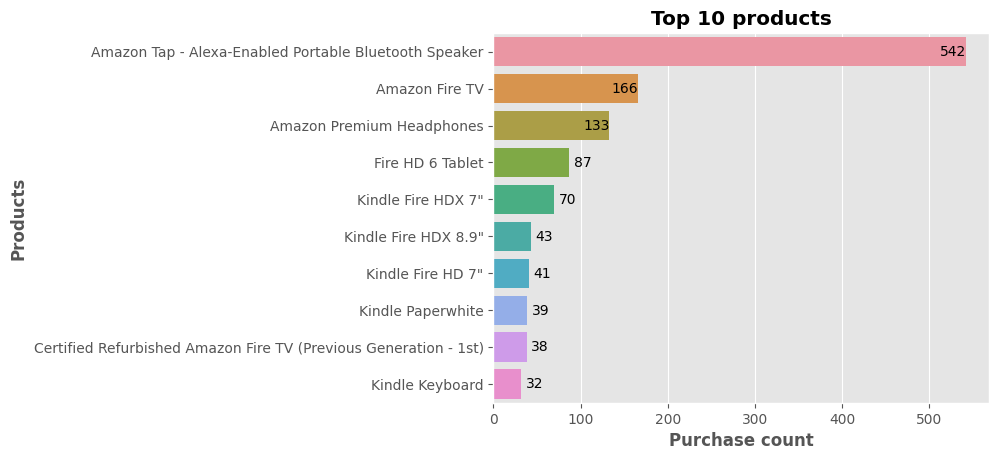

In [220]:
sns.barplot(y = 'name', x = 'count', data = top_10_prod)
plt.xlabel("Purchase count", fontweight = 'bold')
plt.ylabel("Products", fontweight = 'bold')

for y, _, x in top_10_prod.itertuples():
    if(x < 100):
        plt.text(x + 5, y, x, va = 'center' )
    else:
        plt.text(x - 30, y, x, va = 'center')

plt.title("Top 10 products", fontweight = 'bold');

### Product prices

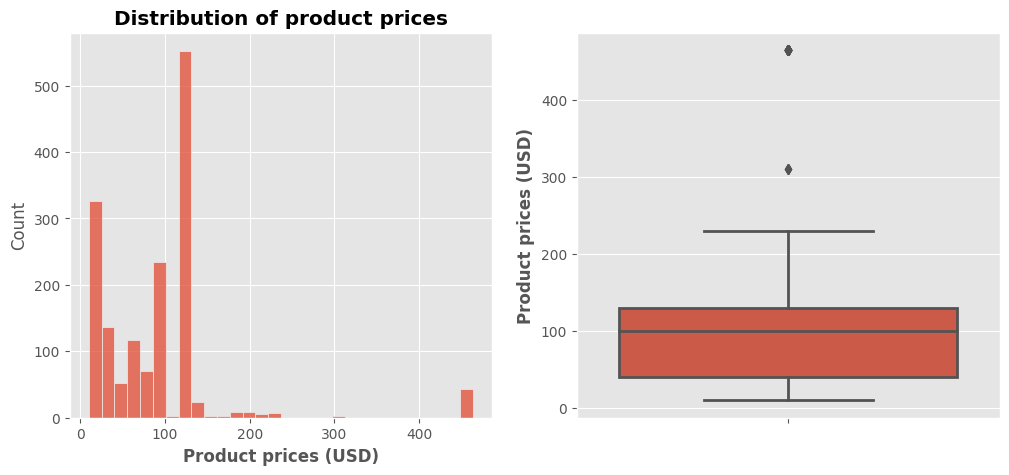

In [221]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(x = 'prices', data = data)
plt.xlabel("Product prices (USD)", fontweight = 'bold')
plt.title("Distribution of product prices", fontweight = 'bold')

plt.subplot(1, 2, 2)
sns.boxplot(y = 'prices', data = data, linewidth=2)
plt.ylabel("Product prices (USD)", fontweight = 'bold');
plt.show()

### Product ratings

In [222]:
prod_rating = data['reviews.rating'].value_counts().to_frame()

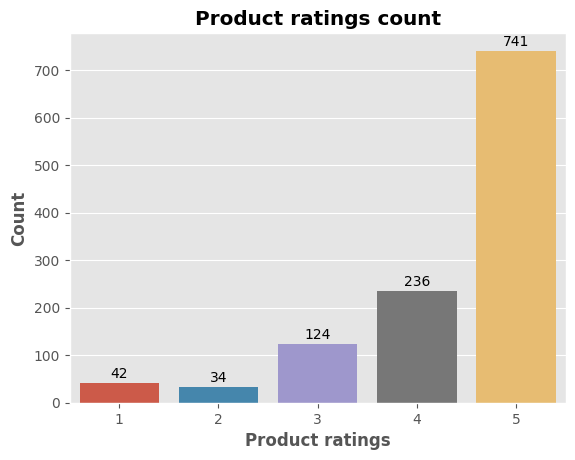

In [223]:
sns.countplot(x = 'reviews.rating', data = data)
plt.xlabel("Product ratings", fontweight = 'bold')
plt.ylabel("Count", fontweight = 'bold')
plt.xticks((0, 1, 2, 3, 4), (1, 2, 3, 4, 5))
plt.title("Product ratings count", fontweight = 'bold');

for x,y in prod_rating.itertuples():
    plt.text(x-1, y + 10, y, ha = 'center')

In [224]:
date_added = data['dateAdded'].value_counts().to_frame().sort_index()

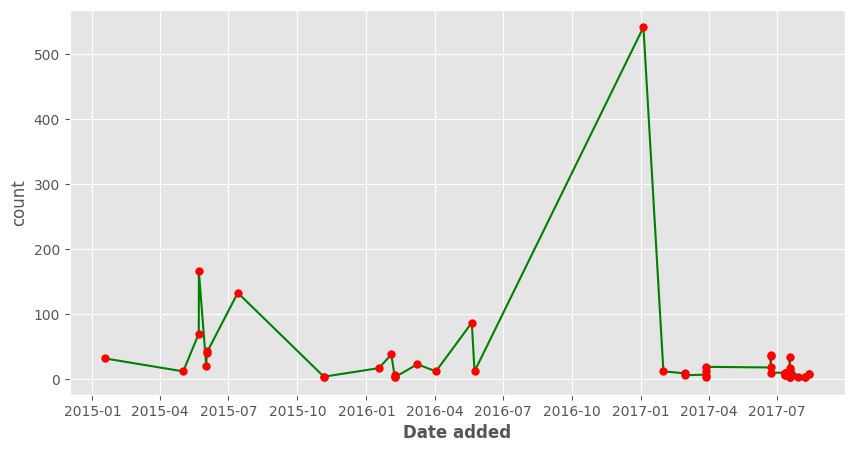

In [225]:
plt.figure(figsize=(10, 5))
sns.lineplot(x = 'dateAdded', y = 'count', data = date_added, marker='o', linewidth = 1.5, c = 'g', markersize = 6, markerfacecolor = 'r', markeredgewidth = 0)
plt.xlabel("Date added", fontweight = 'bold');

# Text preprocessing

In [226]:
nlp = spacy.load('en_core_web_sm')

In [227]:
def clean_text(text):
    text = text.lower()
    text = nlp(text)
    review = []
    for word in text:
        if not any([word.is_punct, word.is_digit, word.is_stop]):
            word = re.sub('[!"#$%&()*+,-/:;<=>?@[\\]^_`{|}~\t\n,0-9]', ' ', word.lemma_)
            review.append(word)
            
    return ' '.join(review)

    

In [228]:
data['reviews.text_cleaned'] = data['reviews.text'].apply(clean_text)

### Remove unicodes (if any)

In [229]:
data['reviews.text_cleaned'] = data['reviews.text_cleaned'].apply(unidecode)

### Remove spaces and empty strings

In [230]:
data = data[~ data['reviews.text_cleaned'].str.isspace()]
data = data[~ data['reviews.text_cleaned'].apply(lambda x : not x)]
data['reviews.text_cleaned']

0       initially trouble decide paperwhite voyage rev...
1       allow preface little history casual reader own...
2       enjoy far great reading original fire fire eye...
3       buy paperwhite pleased constant companion supp...
4       upfront like coroporate hermetically closed st...
                              ...                        
1592    remote get alexa echo control volume think rem...
1593    change battery remote twice month purchase mar...
1594    remote activate connect box a poorly design re...
1595    job super price feel like offer replacement re...
1596    order item replace long work direction new rem...
Name: reviews.text_cleaned, Length: 1596, dtype: object

In [231]:
data.drop_duplicates(inplace = True)

## Text Vectorization using `TfidfVectorizer`

In [232]:
from sklearn.feature_extraction.text import TfidfVectorizer

vect = TfidfVectorizer(min_df = 3, max_df = 0.85)
doc_term_mat = vect.fit_transform(data['reviews.text_cleaned'])   # Document-term matrix

In [233]:
len(vect.vocabulary_)

2221

In [234]:
words = vect.get_feature_names_out()

## Non negative Matrix Factorization (NMF)

In [235]:
n_components = 6

In [236]:
mat_fact = NMF(n_components = n_components, random_state = 42)
mat_fact.fit(doc_term_mat)

NMF(n_components=6, random_state=42)

In [237]:
topic_term_mat = mat_fact.components_

In [238]:
doc_topic_mat = mat_fact.transform(doc_term_mat)

In [239]:
doc_term_mat.shape, doc_topic_mat.shape, topic_term_mat.shape

((1193, 2221), (1193, 6), (6, 2221))

### Top 15 words for #1st topic

In [240]:
', '.join(words[topic_term_mat[0].argsort()[-15:]])

'bluetooth, sling, buy, charge, listen, command, like, button, music, voice, portable, alexa, amazon, echo, tap'

### Top 15 words from all topics

In [241]:
for i in range(n_components):
    print(f"Topic #{i+1}:")
    print(', '.join(words[topic_term_mat[i].argsort()[-15:]]))
    print('\n')

Topic #1:
bluetooth, sling, buy, charge, listen, command, like, button, music, voice, portable, alexa, amazon, echo, tap


Topic #2:
display, keyboard, year, hd, light, tablet, page, fire, model, screen, new, paperwhite, book, read, kindle


Topic #3:
box, game, watch, work, device, search, movie, roku, app, content, remote, amazon, fire, prime, tv


Topic #4:
huge, grey, fan, loose, like, snug, color, plastic, fabric, echo, fit, look, cover, case, dot


Topic #5:
music, price, recommend, work, portable, connect, bluetooth, easy, quality, alexa, use, good, great, speaker, sound


Topic #6:
family, portability, purchase, christmas, get, fun, daughter, play, use, music, product, great, buy, gift, love




## LDA

### Creating Bag of Words (Count vectorization)

In [242]:
from sklearn.feature_extraction.text import CountVectorizer

c_vect = CountVectorizer(min_df = 3, max_df = 0.85)
c_vect.fit(data['reviews.text_cleaned'])

CountVectorizer(max_df=0.85, min_df=3)

In [243]:
X = c_vect.transform(data['reviews.text_cleaned'])
len(c_vect.vocabulary_)

2221

In [244]:
X.shape

(1193, 2221)

In [245]:
lda = LDA(n_components = n_components, random_state = 42, n_jobs = -1)
lda.fit(X)

LatentDirichletAllocation(n_components=6, n_jobs=-1, random_state=42)

In [246]:
lda.components_.shape

(6, 2221)

### Top 15 words from all the topics

In [247]:
for i in range(n_components):
    print(f"Topic #{i+1}:")
    print(', '.join(words[lda.components_[i].argsort()[-15:]]))
    print('\n')

Topic #1:
tablet, buy, phone, device, new, remote, cover, purchase, time, screen, work, amazon, case, fire, kindle


Topic #2:
new, display, read, model, video, screen, year, app, hd, device, hdx, kindle, amazon, tablet, fire


Topic #3:
remote, use, like, netflix, movie, game, app, fire, box, content, search, prime, roku, amazon, tv


Topic #4:
review, reader, old, turn, love, buy, page, like, screen, light, new, paperwhite, book, read, kindle


Topic #5:
case, good, sling, buy, speaker, cover, echo, look, use, dot, sound, tap, great, like, love


Topic #6:
want, buy, use, voice, good, work, sound, music, device, speaker, alexa, amazon, great, tap, echo




### Choosing the results obtained from NMF for finalizing the topics

In [248]:
topics = {
    0 : 'Amazon Alexa Devices and Audio Control',
    1 : 'Amazon Kindle and E-Readers',
    2 : 'Streaming Devices and Content Consumption',
    3 : 'Amazon Echo Accessories and Customization',
    4 : 'Portable Bluetooth Speakers',
    5 : 'Family Gift Purchase and Enjoyment'
}

In [249]:
data.set_index(np.arange(0, 1193), inplace = True)
data.drop(columns = ['reviews.text_cleaned'], inplace=True)
data.head()

,name,prices,dateAdded,reviews.text,reviews.rating
0,Kindle Paperwhite,139.99,2016-03-08 20:21:53+00:00,I initially had trouble deciding between the p...,5.0
1,Kindle Paperwhite,139.99,2016-03-08 20:21:53+00:00,Allow me to preface this with a little history...,5.0
2,Kindle Paperwhite,139.99,2016-03-08 20:21:53+00:00,I am enjoying it so far. Great for reading. Ha...,4.0
3,Kindle Paperwhite,139.99,2016-03-08 20:21:53+00:00,I bought one of the first Paperwhites and have...,5.0
4,Kindle Paperwhite,139.99,2016-03-08 20:21:53+00:00,I have to say upfront - I don't like coroporat...,5.0


In [250]:
review_topics = pd.Series(doc_topic_mat.argmax(axis = 1))
data['review_topic'] = review_topics.map(topics)
data.head()

,name,prices,dateAdded,reviews.text,reviews.rating,review_topic
0,Kindle Paperwhite,139.99,2016-03-08 20:21:53+00:00,I initially had trouble deciding between the p...,5.0,Amazon Kindle and E-Readers
1,Kindle Paperwhite,139.99,2016-03-08 20:21:53+00:00,Allow me to preface this with a little history...,5.0,Amazon Kindle and E-Readers
2,Kindle Paperwhite,139.99,2016-03-08 20:21:53+00:00,I am enjoying it so far. Great for reading. Ha...,4.0,Amazon Kindle and E-Readers
3,Kindle Paperwhite,139.99,2016-03-08 20:21:53+00:00,I bought one of the first Paperwhites and have...,5.0,Amazon Kindle and E-Readers
4,Kindle Paperwhite,139.99,2016-03-08 20:21:53+00:00,I have to say upfront - I don't like coroporat...,5.0,Amazon Kindle and E-Readers


## Vislualize topics

In [264]:
topic_count = data['review_topic'].value_counts(sort = False).reset_index()
topic_count

,review_topic,count
0,Amazon Kindle and E-Readers,209
1,Amazon Alexa Devices and Audio Control,153
2,Family Gift Purchase and Enjoyment,186
3,Streaming Devices and Content Consumption,279
4,Portable Bluetooth Speakers,228
5,Amazon Echo Accessories and Customization,138


Text(0.5, 1.0, 'Review topic counts')

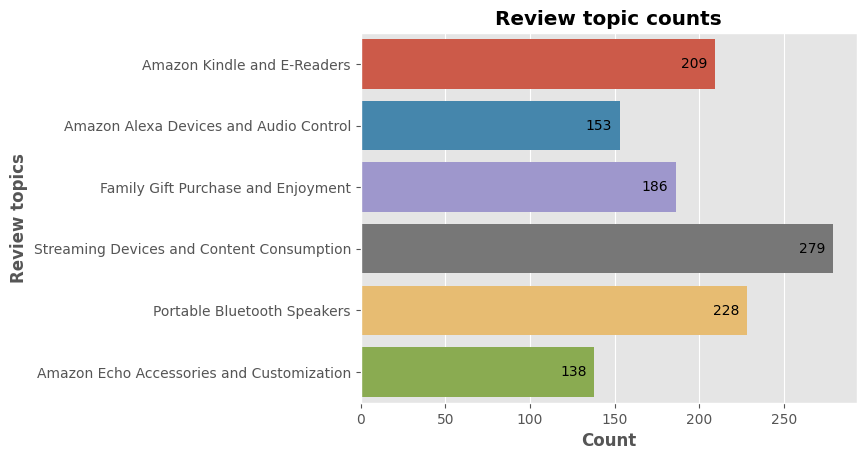

In [272]:
sns.barplot(y = 'review_topic', x = 'count', data = topic_count)

for y,_,x in topic_count.itertuples():
    plt.text(x - 20, y, x, va = 'center')

plt.ylabel("Review topics", fontweight = 'bold')
plt.xlabel("Count", fontweight = 'bold')
plt.title("Review topic counts", fontweight = 'bold')